In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
from tqdm import tqdm

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from sklearn.metrics.pairwise import cosine_similarity
import scipy

In [3]:
DATA_FOLDER='./data/'
PATHS_AND_GRAPH = DATA_FOLDER + 'wikispeedia_paths-and-graph/'
PATHS_FINISHED = PATHS_AND_GRAPH + 'paths_finished.tsv'
PATHS_UNFINISHED = PATHS_AND_GRAPH + 'paths_unfinished.tsv'

In [4]:
#data exploration
paths_finished = pd.read_csv(PATHS_FINISHED, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'], encoding='utf-8', skiprows=16).copy(deep=True)
paths_finished["timestamp"] = pd.to_datetime(paths_finished["timestamp"], unit='s')
paths_finished.head()


,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,2011-02-15 03:26:49,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,2012-08-12 06:36:52,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,2012-10-03 21:10:40,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,2013-04-23 15:27:08,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [5]:
import os
os.listdir('./data')

['wikispeedia_paths-and-graph']

In [6]:
paths_unfinished= pd.read_csv(PATHS_UNFINISHED, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'], encoding='utf-8', skiprows=17).copy(deep=True)
paths_unfinished["timestamp"] = pd.to_datetime(paths_unfinished["timestamp"], unit='s')
paths_unfinished.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,2011-02-07 05:02:15,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,2011-02-07 05:14:11,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,2011-02-07 15:00:19,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,2011-02-07 16:06:01,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,2011-02-07 17:18:25,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


## BERTscore semantic similarity metric on data

In [7]:
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER") # Named entity recognition-specific model!

def compute_sim(s1, s2):
	enc1 = tokenizer.encode(s1, return_tensors='pt').reshape(1, -1)
	enc2 = tokenizer.encode(s2, return_tensors='pt').reshape(1, -1)

	trunc = min(enc1.size(dim=1), enc2.size(dim=1))

	enc1 = enc1[:, :trunc]
	enc2 = enc2[:, :trunc]

	return cosine_similarity(enc1, enc2).squeeze().item()

In [8]:
compute_sim('That\'s cool bro!', 'Yeah, thanks man.')

0.17891668381127587

In [9]:
compute_sim('I am 6 years old', 'I am 10 years old')

0.9178431127887152

In [10]:
sucessive_pairs = [[(x.split(';')[i], x.split(';')[i+1]) for i in range(len(x.split(';')) - 1)] for x in paths_finished['path'].to_list()]
print(sucessive_pairs[:2])

[[('14th_century', '15th_century'), ('15th_century', '16th_century'), ('16th_century', 'Pacific_Ocean'), ('Pacific_Ocean', 'Atlantic_Ocean'), ('Atlantic_Ocean', 'Accra'), ('Accra', 'Africa'), ('Africa', 'Atlantic_slave_trade'), ('Atlantic_slave_trade', 'African_slave_trade')], [('14th_century', 'Europe'), ('Europe', 'Africa'), ('Africa', 'Atlantic_slave_trade'), ('Atlantic_slave_trade', 'African_slave_trade')]]


In [11]:
sucessive_pairs_encoded = [[compute_sim(*a) for a in x] for x in tqdm(sucessive_pairs)]

100%|██████████| 51318/51318 [02:16<00:00, 374.89it/s]


In [116]:
from collections import defaultdict
global_dict = defaultdict(list)

for i in range(len(sucessive_pairs)):
	local_rating = paths_finished['rating'][i]
	for key, value in zip(sucessive_pairs[i], sucessive_pairs_encoded[i]):
		global_dict[key].append((local_rating, value))

global_dict = {key: np.array(value) for key, value in global_dict.items()}
edge_score_df = pd.DataFrame({
	'edge': global_dict.keys(),
	'mean_bert_score': [np.nanmean(a[:, 1]) for a in global_dict.values()], 'mean_rating':[np.nanmean(a[:, 0]) for a in global_dict.values()]})
display(edge_score_df)

/tmp/ipykernel_5932/145660030.py:12: RuntimeWarning: Mean of empty slice


,edge,mean_bert_score,mean_rating
0,"(14th_century, 15th_century)",0.999987,2.600000
1,"(15th_century, 16th_century)",0.999637,2.428571
2,"(16th_century, Pacific_Ocean)",0.700767,NaN
3,"(Pacific_Ocean, Atlantic_Ocean)",0.990600,2.521739
4,"(Atlantic_Ocean, Accra)",0.098035,NaN
...,...,...,...
55142,"(Yagan, Folklore)",0.706183,3.000000
55143,"(A_Christmas_Carol, Novel)",0.582377,3.000000
55144,"(Yagan, Australia)",0.979503,NaN
55145,"(Yarralumla%2C_Australian_Capital_Territory, A...",0.842705,1.000000


/home/laurent/micromamba/envs/ada/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/laurent/micromamba/envs/ada/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/laurent/micromamba/envs/ada/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/laurent/micromamba/envs/ada/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/home/laurent/micromamba/envs/ada/lib/python3.11/site-packages/seaborn/_oldcore.py:1

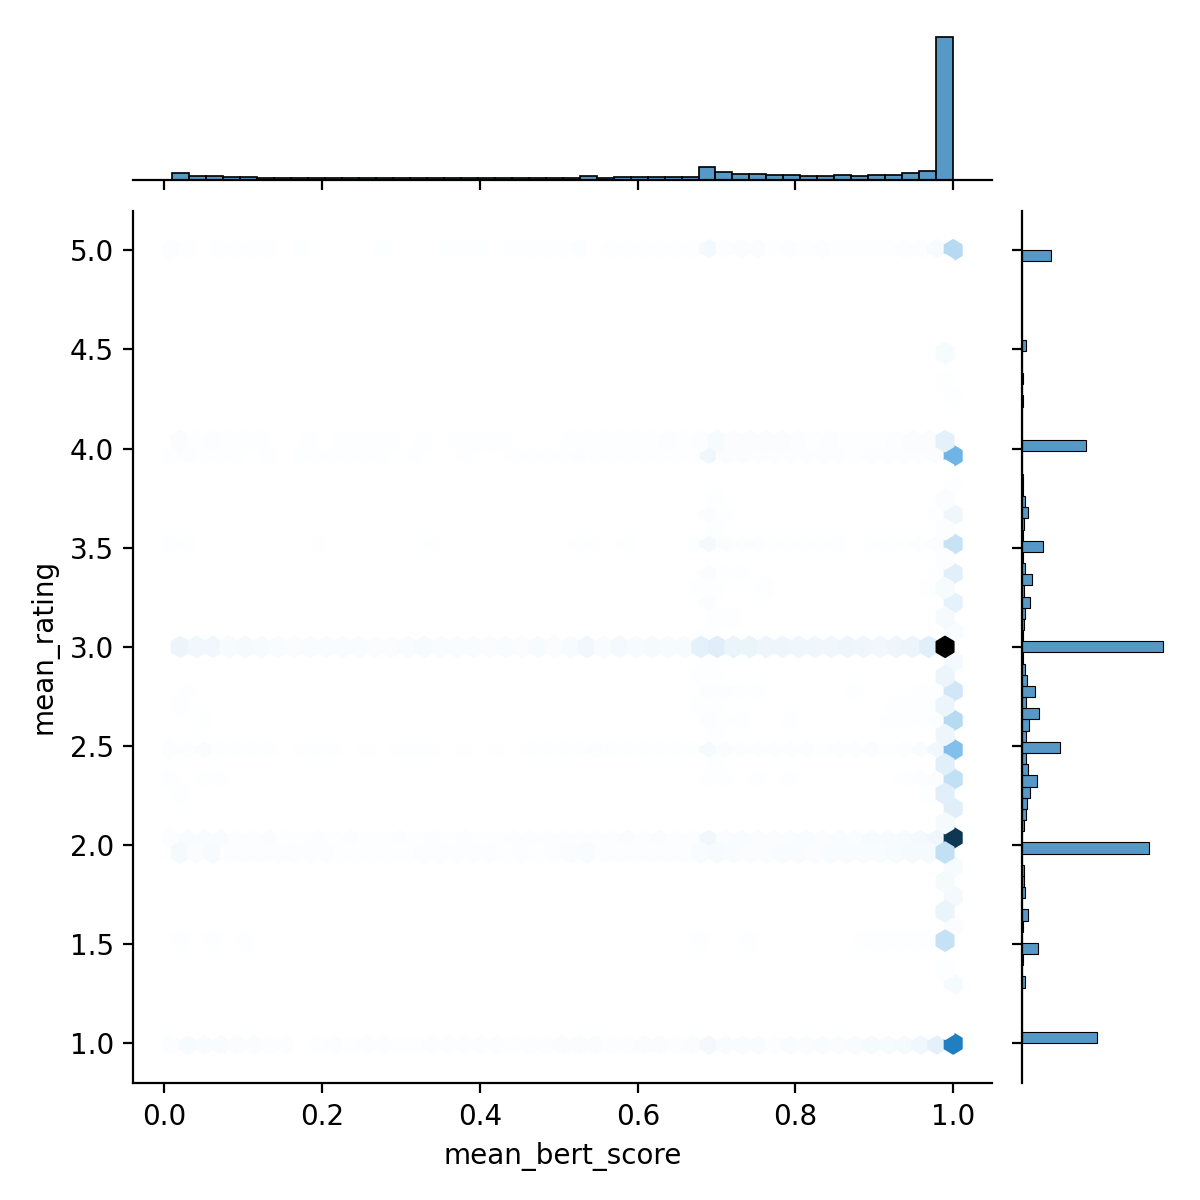

In [120]:
sns.jointplot(data=edge_score_df,
			  x='mean_bert_score',
			  y='mean_rating',
			  kind='hex'
)
plt.show()

In [50]:
sucessive_pairs_encoded_mean = [np.mean(x) for x in sucessive_pairs_encoded]
sucessive_pairs_encoded_mean[:5]

/home/laurent/micromamba/envs/ada/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
/home/laurent/micromamba/envs/ada/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide


[0.7284729586204293,
 0.996099050367021,
 0.9189520328545707,
 0.9999213535320469,
 0.8641020573853648]

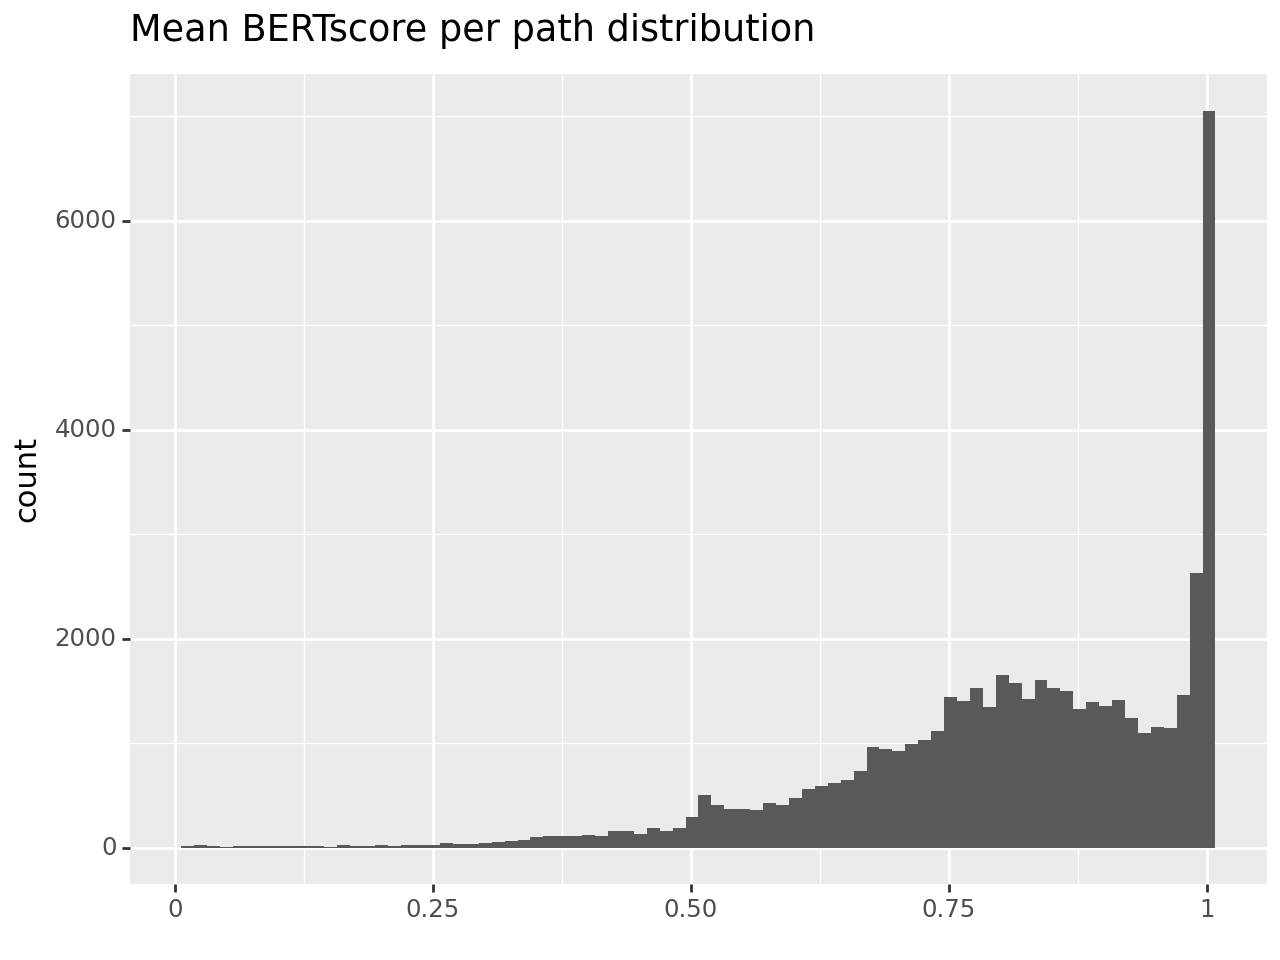

<Figure Size: (640 x 480)>

In [117]:
ggplot() + geom_histogram(aes(x=sucessive_pairs_encoded_mean), bins=80) + labs(title='Mean BERTscore per path distribution')

Awesome. This looks like another metric we could use! Looks mostly Gaussian. Maybe we should look into all those values close to 1. All the rest is nice though!

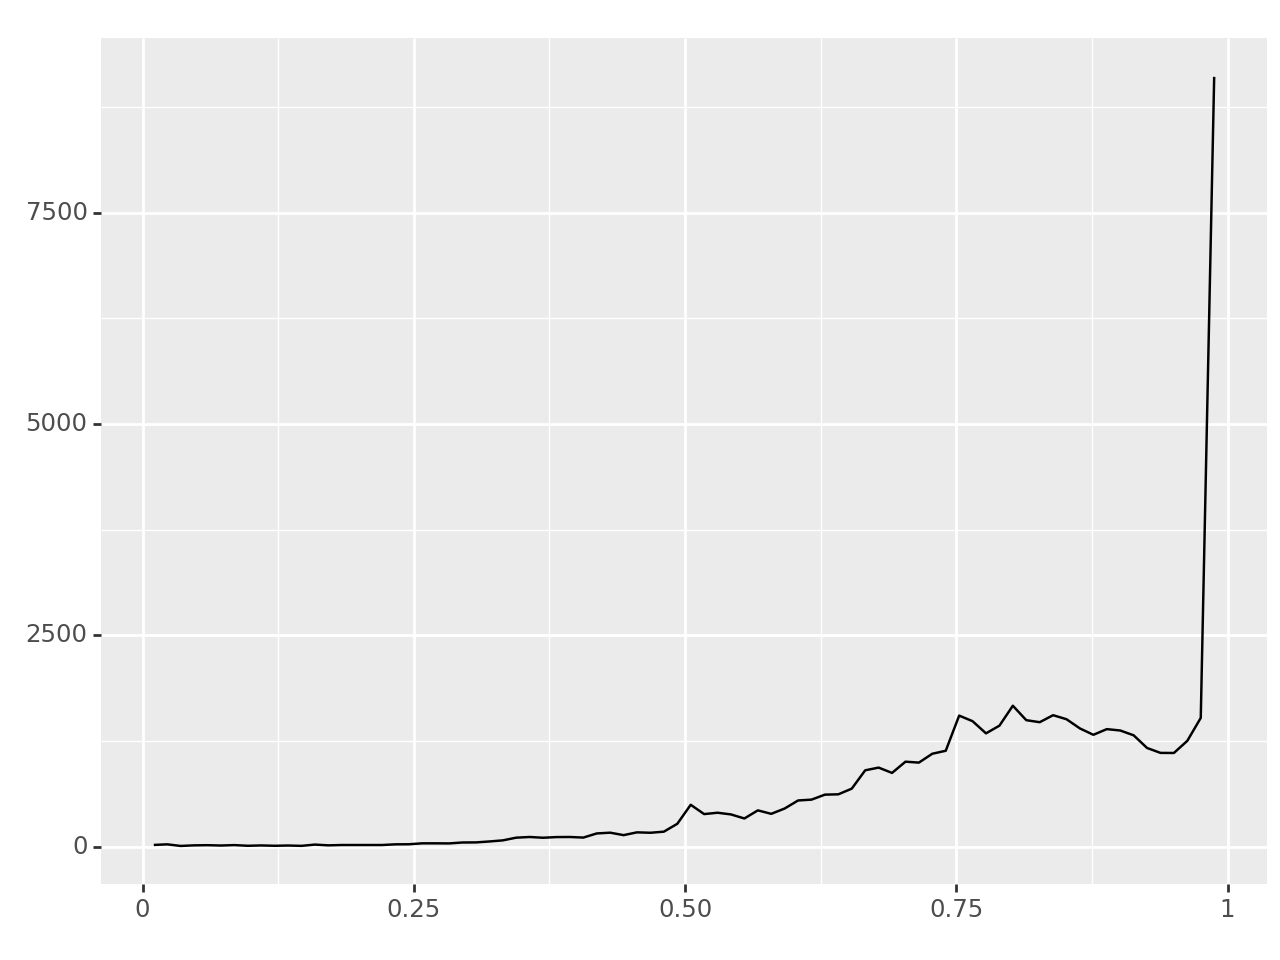


'Gaussianity' shaprio test p-value: 2.401617079305588e-15


In [52]:
sucessive_pairs_encoded_mean = np.array(sucessive_pairs_encoded_mean)
aligned_finished_scores = paths_finished['rating'].to_numpy()[~np.isnan(sucessive_pairs_encoded_mean)] # This is for later
sucessive_pairs_encoded_mean = sucessive_pairs_encoded_mean[~np.isnan(sucessive_pairs_encoded_mean)]

np_hist = np.histogram(sucessive_pairs_encoded_mean, bins=80)

print(ggplot(aes(x=np_hist[1][:-1], y=np_hist[0])) + geom_line())

print("'Gaussianity' shaprio test p-value:", scipy.stats.shapiro(np_hist[0]).pvalue)

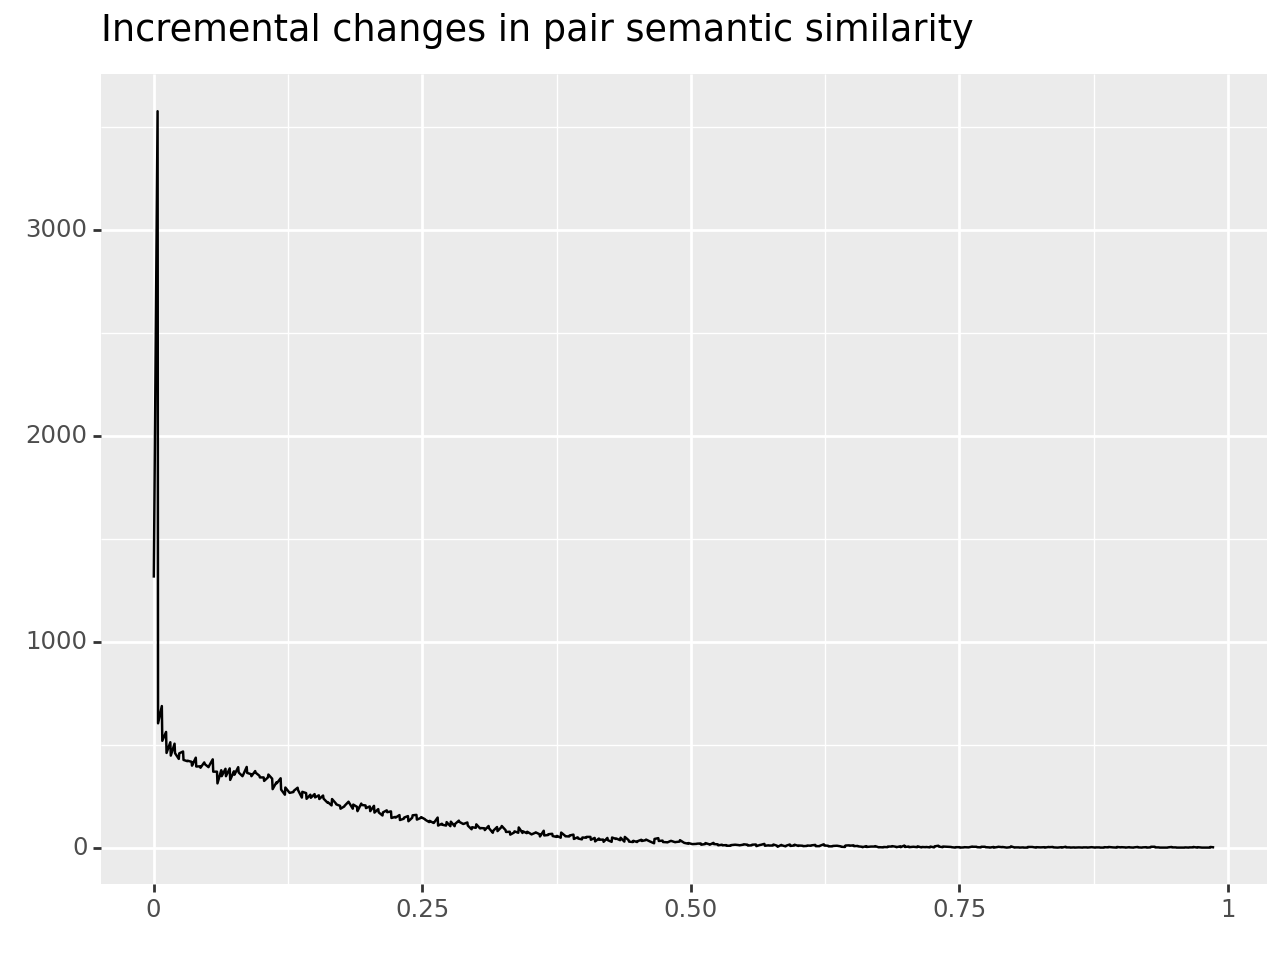


'Gaussianity' shaprio test p-value: 9.119045044889321e-37
Normal test p-value: 1.319254394604777e-180


/home/laurent/micromamba/envs/ada/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:7940: RuntimeWarning: overflow encountered in divide
/home/laurent/micromamba/envs/ada/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce


Power-law test p-value: 0.000999000999000999
Something's weird here...


In [101]:
pairs_diffs = np.diff(sucessive_pairs_encoded_mean)

np_hist2 = np.histogram(pairs_diffs, bins=500)

print(ggplot(aes(x=np.abs(np_hist2[1][:-1]), y=np_hist2[0])) + geom_line() + labs(title='Incremental changes in pair semantic similarity'))

print("'Gaussianity' shaprio test p-value:", scipy.stats.shapiro(np_hist2[0]).pvalue)
print("Normal test p-value:", scipy.stats.normaltest(np_hist2[0]).pvalue)
print("Power-law test p-value:", scipy.stats.goodness_of_fit(dist=scipy.stats.powerlaw, data=np_hist2[0], n_mc_samples=1000).pvalue)
print("Something's weird here...")

/home/laurent/micromamba/envs/ada/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/laurent/micromamba/envs/ada/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/laurent/micromamba/envs/ada/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/laurent/micromamba/envs/ada/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/home/laurent/micromamba/envs/ada/lib/python3.11/site-packages/seaborn/_oldcore.py:1

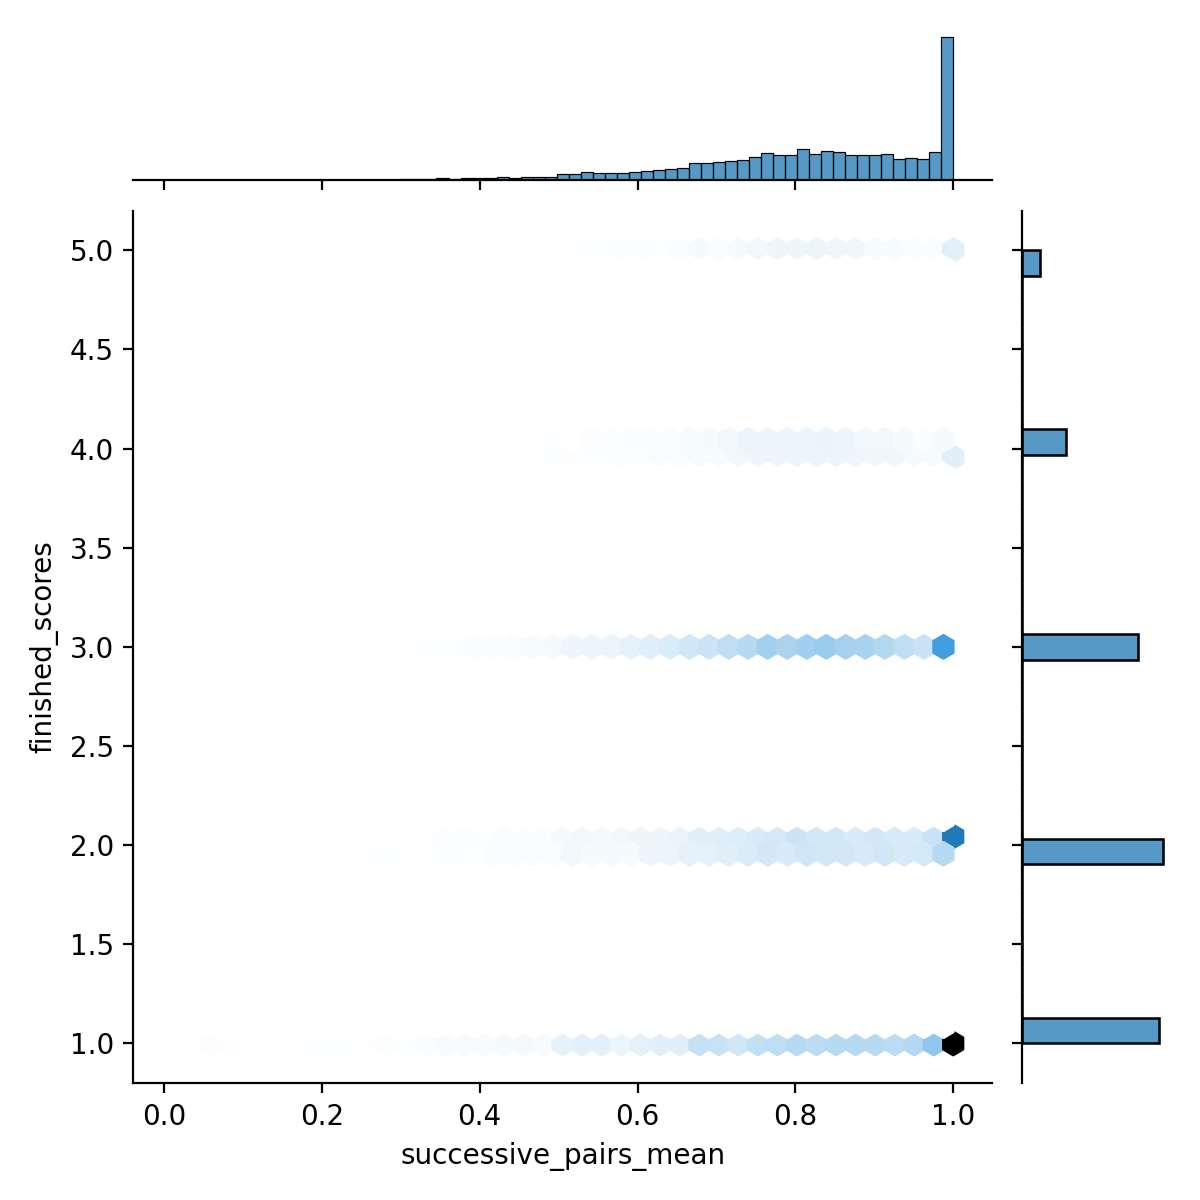

In [87]:
mean_BERT_and_score = pd.DataFrame({'successive_pairs_mean': sucessive_pairs_encoded_mean,
			  'finished_scores': aligned_finished_scores})

sns.jointplot(data=mean_BERT_and_score,
			  x='successive_pairs_mean',
			  y='finished_scores',
			  kind='hex'
)
plt.show()